# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [2]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [45]:
#將資料分別存成兩個不同變數
training_data = pd.read_csv('data/train.csv')
testing_data = pd.read_csv('data/test.csv')

#資料處理:
#資料讀取->看遺漏值->判斷重要性或是缺漏多寡->太多: drop; 不多: fillna
#再來做label encoder->scaler
#確認資料沒問題->分群train_test_split

#確認各特徵值有多少個nulls資料
def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [46]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
testing_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [48]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivor
training_data.drop(labels=['Cabin','Ticket','Name'],axis=1, inplace=True) #drop整個欄位並取代
testing_data.drop(labels=['Cabin','Ticket','Name'],axis=1, inplace=True)

# Taking the mean/average value would be impacted by the skew #填補值
# so we should use the median value to impute missing values
#training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
training_data['Age'].fillna(training_data['Age'].median(),inplace=True) #針對Age欄位，將沒有資料的欄位塞入中位數，並取代
testing_data['Age'].fillna(testing_data['Age'].median(),inplace=True)

training_data['Embarked'].fillna('S',inplace=True) #直接填值

testing_data['Fare'].fillna(training_data['Fare'].median(),inplace=True) #填中位數

get_nulls(training_data, testing_data) #再次確認是否有缺漏

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [49]:
training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [50]:
testing_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [51]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])
training_embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked"] = training_embarked_encoded
test_embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked"] = test_embarked_encoded

#讓Age和Fare做scale
#首先，要先做轉換
# Any value we want to reshape needs be turned into array first
#[Age]
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
#[Fare]
fare_train = np.array(training_data["Fare"]).reshape(-1, 1)
fare_test = np.array(testing_data["Fare"]).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
training_data["Fare"] = scaler.fit_transform(fare_train)
testing_data["Fare"] = scaler.fit_transform(fare_test)

In [52]:
# Now to select our training/testing data
#PassengerID用不到，Survived是要做的目標，都drop
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print('X_features:')
print(X_features.head(5))
print('y_labels:')
print(y_labels.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

#前處理結束

X_features:
   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2
y_labels:
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [53]:
#stacking
#different classifier
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()
#各自學習
LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)
#驗證預測值
LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)


#final predict
averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8


## Bagging Classification Example

In [54]:
#2bagging
logreg_bagging_model=BaggingClassifier(base_estimator=LogReg_clf,n_estimators=50,random_state=12)
dtree_bagging_model=BaggingClassifier(base_estimator=DTree_clf,n_estimators=50,random_state=12)
#random forest
random_forest=RandomForestClassifier(n_estimators=100,random_state=12)
#extra trees
extra_trees=ExtraTreesClassifier(n_estimators=100,random_state=12)

def bagging_ensemble(model):
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True) #切20堆
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    return (results.mean())

print('logreg_bagging_model:',bagging_ensemble(logreg_bagging_model))
print('dtree_bagging_model:',bagging_ensemble(dtree_bagging_model))
print('random_forest:',bagging_ensemble(random_forest))
print('extra_trees:',bagging_ensemble(extra_trees))

logreg_bagging_model: 0.7927134146341464
dtree_bagging_model: 0.8188719512195123
random_forest: 0.8113719512195123
extra_trees: 0.7963719512195122


## Boosting Classification Example

In [55]:
k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
num_estimators = [1 , 5 , 10, 20, 30 , 35 , 40, 60, 80, 100] #觀察不同的estimators是否有不同結果
num_estimators_mean=[]


for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12) 
    results = cross_val_score(ada_boost,X_train, y_train,cv=k_folds)
    num_estimators_mean.append(results.mean())
    print("Results for {} estimators:".format(i))
    print(results.mean())
print(num_estimators_mean)

Results for 1 estimators:
0.7889939024390243
Results for 5 estimators:
0.7989329268292683
Results for 10 estimators:
0.8051829268292684
Results for 20 estimators:
0.8052134146341464
Results for 30 estimators:
0.8101829268292684
Results for 35 estimators:
0.8151829268292683
Results for 40 estimators:
0.8176524390243903
Results for 60 estimators:
0.8164329268292683
Results for 80 estimators:
0.8151524390243902
Results for 100 estimators:
0.8101524390243903
[0.7889939024390243, 0.7989329268292683, 0.8051829268292684, 0.8052134146341464, 0.8101829268292684, 0.8151829268292683, 0.8176524390243903, 0.8164329268292683, 0.8151524390243902, 0.8101524390243903]


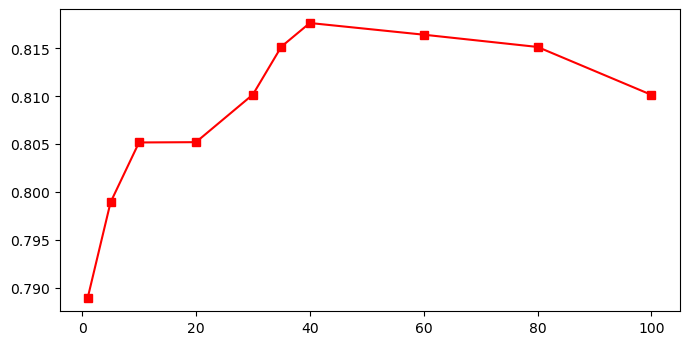

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=100,linewidth = 2)
plt.plot(num_estimators,num_estimators_mean,'s-',color = 'r', label="Estimators num VS Score")

## voting\Stacking Classification Example

In [57]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
#'名稱',方法

#訓練
voting_clf.fit(X_train, y_train)
#確認預測值
preds = voting_clf.predict(X_val)
#計算評分分數
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8333333333333334
Log Loss is: 5.756516038980461
F1 Score is: 0.7761194029850748


In [58]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
715,3,1,-0.796286,0,0,-0.494391,2
319,1,0,0.817561,1,1,2.059694,0
829,1,0,2.508257,0,0,0.962353,2
79,3,0,0.049062,0,0,-0.397241,2
484,1,1,-0.335187,1,0,1.185430,0
...,...,...,...,...,...,...,...
241,3,0,-0.104637,1,0,-0.336334,1
253,3,1,0.049062,1,0,-0.324253,2
390,1,1,0.510161,1,2,1.767741,2
667,3,1,-0.104637,0,0,-0.491874,2


In [59]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,0.386231,0,0,-0.497413,1
1,893,3,0,1.371370,1,0,-0.512278,2
2,894,2,1,2.553537,0,0,-0.464100,1
3,895,3,1,-0.204852,0,0,-0.482475,2
4,896,3,0,-0.598908,1,1,-0.417492,2
...,...,...,...,...,...,...,...,...
413,1305,3,1,-0.204852,0,0,-0.493455,2
414,1306,1,0,0.740881,0,0,1.314435,0
415,1307,3,1,0.701476,0,0,-0.507796,2
416,1308,3,1,-0.204852,0,0,-0.493455,2


In [60]:
test=testing_data.drop(labels=['PassengerId'],axis=1)
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,0.386231,0,0,-0.497413,1
1,3,0,1.371370,1,0,-0.512278,2
2,2,1,2.553537,0,0,-0.464100,1
3,3,1,-0.204852,0,0,-0.482475,2
4,3,0,-0.598908,1,1,-0.417492,2
...,...,...,...,...,...,...,...
413,3,1,-0.204852,0,0,-0.493455,2
414,1,0,0.740881,0,0,1.314435,0
415,3,1,0.701476,0,0,-0.507796,2
416,3,1,-0.204852,0,0,-0.493455,2


In [62]:
submission_df=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df

,PassengerId,Survived


In [63]:
submission_df['PassengerId']=testing_data['PassengerId']
preds_test = voting_clf.predict(test)
submission_df['Survived']=preds_test

In [64]:
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [65]:
submission_df.to_csv('sumission.csv',header=True,index=False)